# Figure: A Core Urban Microbiome

In [12]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [25]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)
library(ape)
library(ggtree)
library(tidyr)


In [120]:
taxa = core_tabler.taxonomy()
print(taxa.shape)

def prevalence(df, thresh=0, count=False):
    """Return the prevalence of each column in a dataframe."""
    return (df > thresh).sum(axis=0) / (1 if count else df.shape[0])

prev = pd.DataFrame({
    'total': prevalence(taxa),
    'city': taxa.groupby(by=core_tabler.metadata['city']).apply(prevalence).mean(axis=0),
})
prev['taxa'] = prev.index
print(prev.shape)
prev_flat = prev.melt(id_vars='taxa')
prev_flat.head()

pt = prev_flat.query('variable == "total"')
print(pt.query('value < 0.25').shape)
print(pt.query('value < 0.95').query('value >= 0.25').shape)
print(pt.query('value > 0.95').shape)

(3639, 4424)
(4424, 3)
(2466, 3)
(1897, 3)
(61, 3)


In [16]:
100 * prev.loc[['Cutibacterium acnes', 'Cupriavidus metallidurans', 'Candida dubliniensis']]

,total,city,taxa
Cutibacterium acnes,99.093157,99.903907,Cutibacterium acnesCutibacterium acnesCutibact...
Cupriavidus metallidurans,89.145370,89.900326,Cupriavidus metalliduransCupriavidus metallidu...
Candida dubliniensis,64.358340,68.286886,Candida dubliniensisCandida dubliniensisCandid...


In [174]:
core_taxa = pd.read_csv(core_tabler.packet_dir + '/taxonomy/core_taxa_95perc.annotated.csv')
core_taxa['biofilm_forming'] = core_taxa['biofilm_forming'].map(lambda x: 'forms films' if x == 1 else 'no films')
core_taxa['commensal'] = core_taxa['commensal'].map(lambda x: 'commensal' if x == 'yes' else 'not commensal')
core_taxa.head()

,taxa,phyla,gram_stain,commensal,antimicrobial_susceptibility,optimal_temperature,extreme_environment,biofilm_forming,optimal_ph,animal_pathogen,spore_forming,pathogenicity,plant_pathogen
0,Corynebacterium variabile,Actinobacteria,positive,not commensal,NaN,NaN,0.0,no films,NaN,0.0,NaN,NaN,0.0
1,Kocuria rhizophila,Actinobacteria,positive,not commensal,1.0,NaN,0.0,no films,NaN,1.0,NaN,1.0,0.0
2,Propionibacterium freudenreichii,Actinobacteria,positive,not commensal,NaN,30.0,0.0,no films,7.2,0.0,0.0,2.0,0.0
3,Lactococcus lactis,Firmicutes,positive,not commensal,NaN,NaN,0.0,no films,6.6,0.0,0.0,1.0,0.0
4,Enterobacter cloacae,Proteobacteria,negative,not commensal,1.0,NaN,NaN,forms films,7.0,0.0,0.0,2.0,1.0


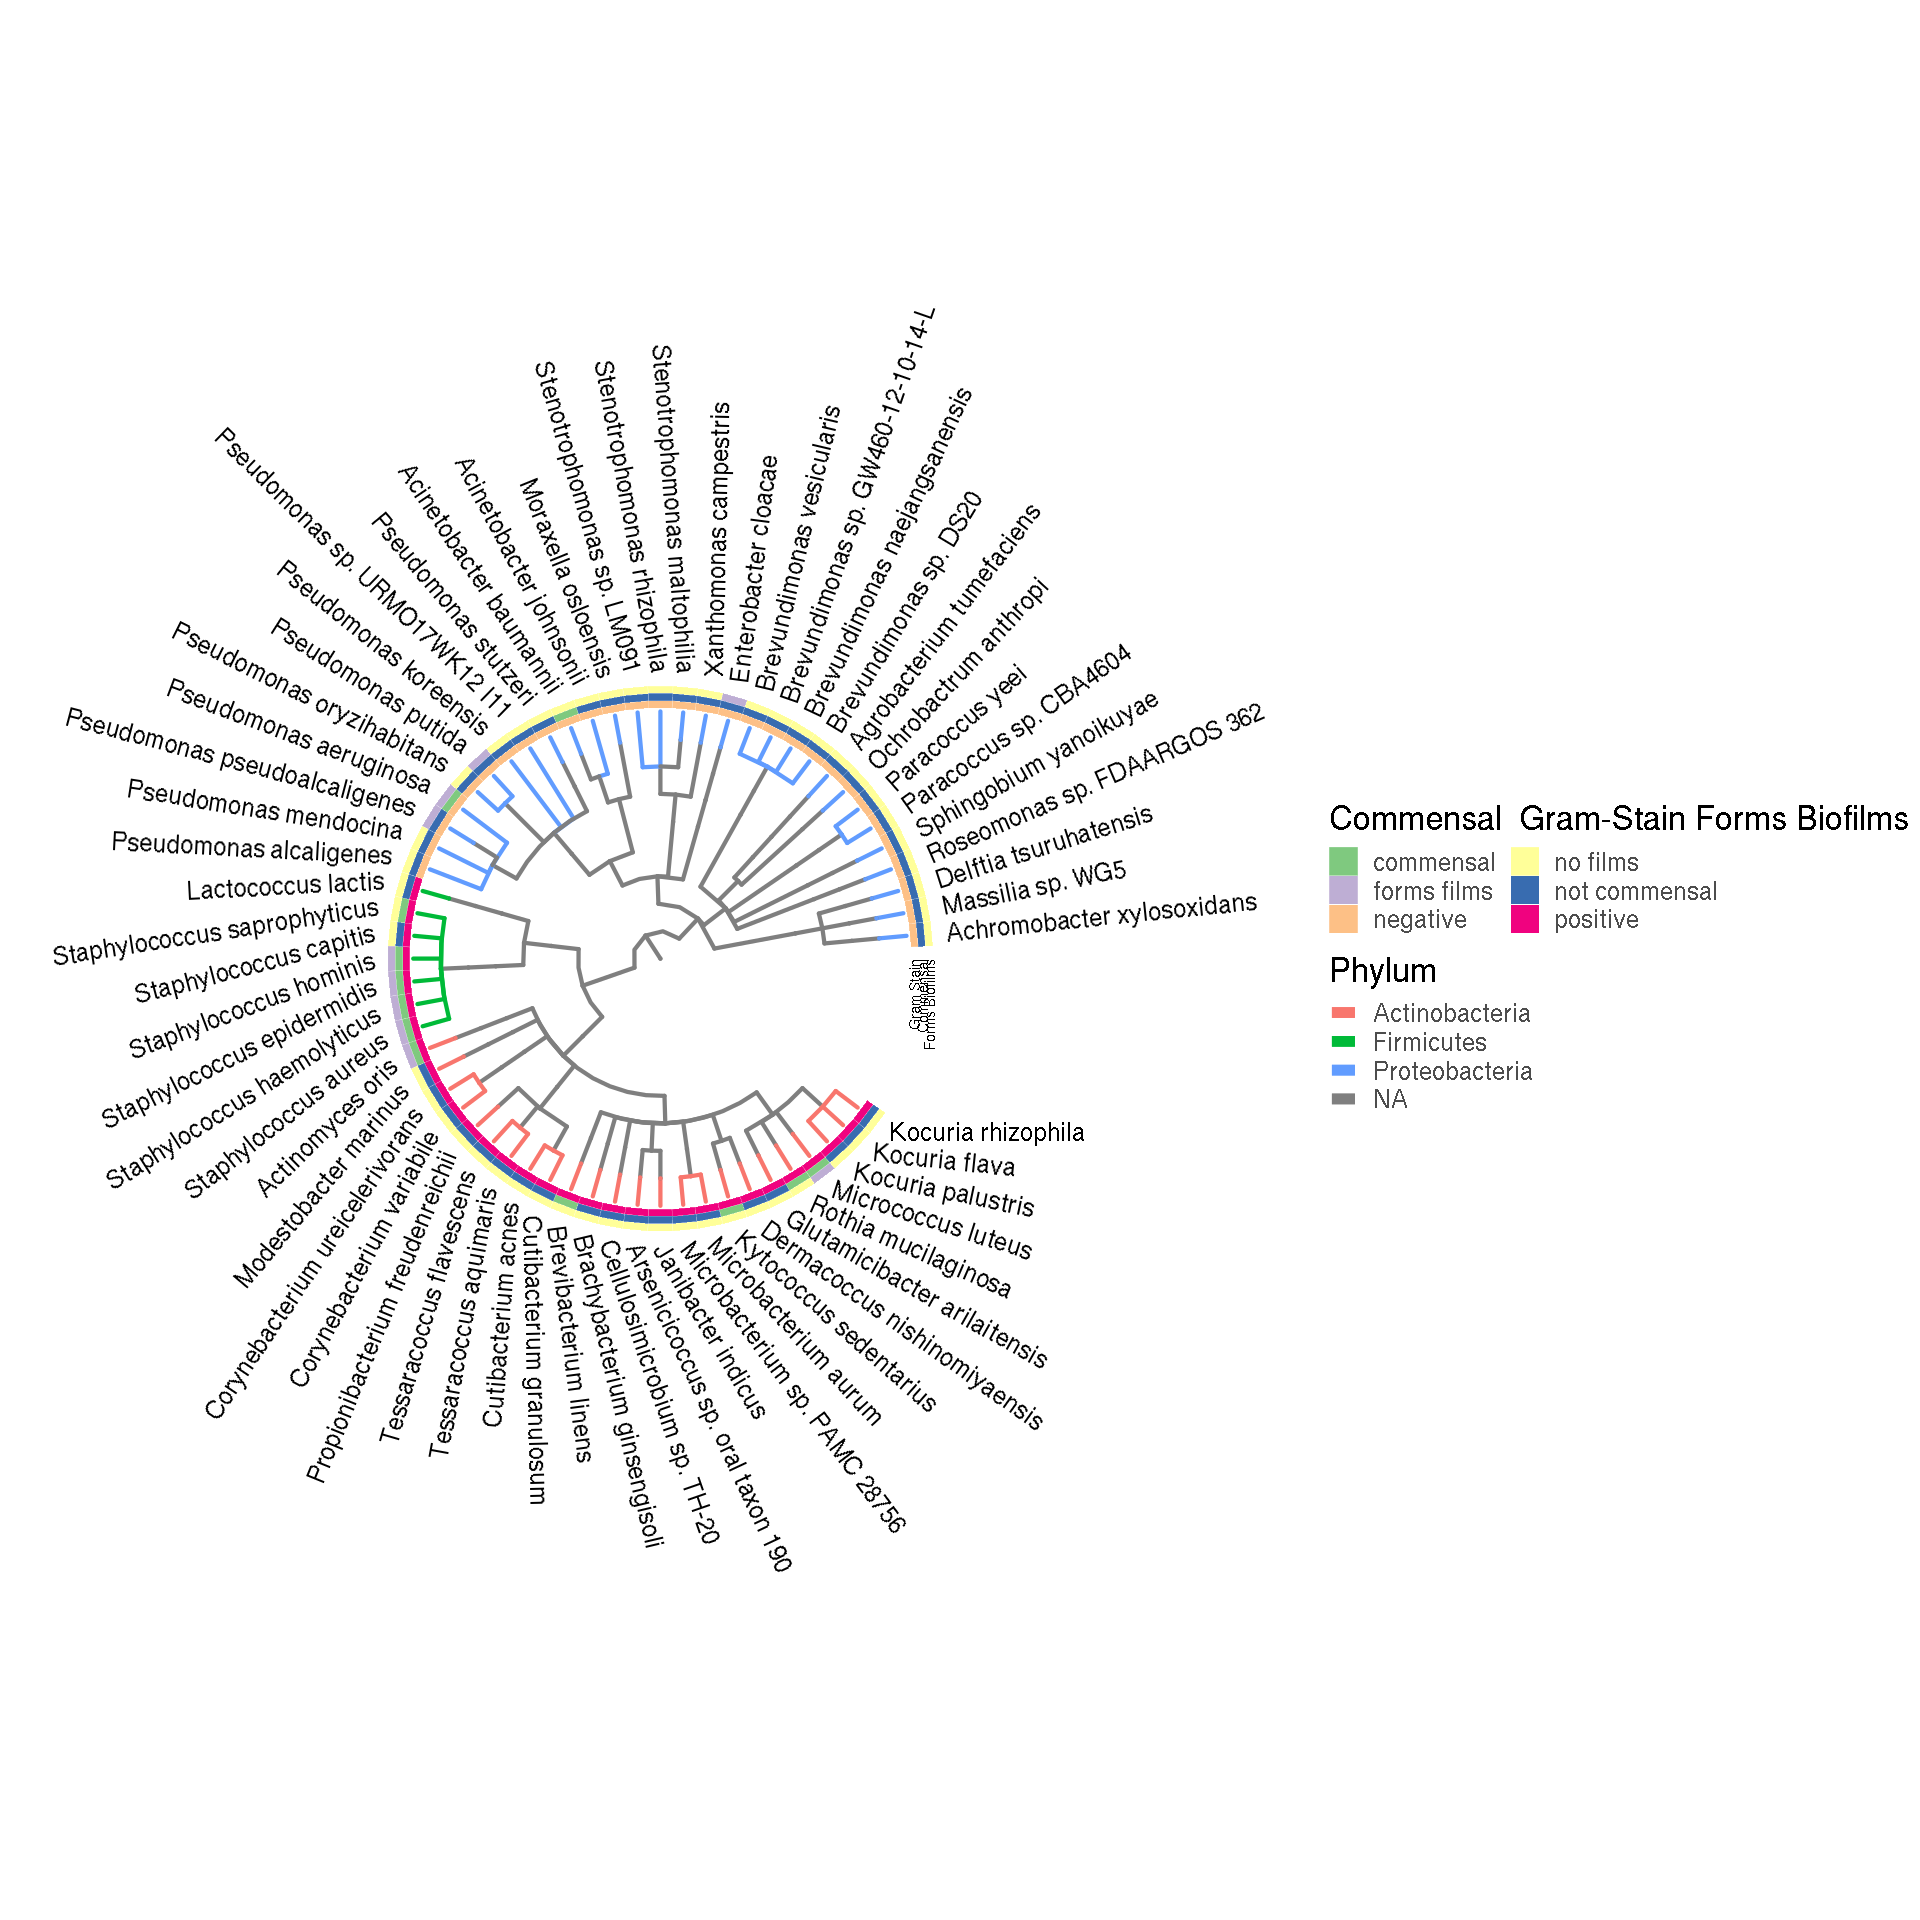

In [176]:
%%R -i core_taxa -w 1920 -h 1920

### Core tree METASUB 2019
## Author Maria A. Sierra

tree.core = read.nexus("/home/dcdanko/Dropbox/resources_and_shared/release_packet_jun12_2019/taxonomy/core_taxa_95perc_nexus.txt")
tree.core$tip.label = unlist(lapply(strsplit(tree.core$tip.label, "_"), FUN=function(x){paste0(x, collapse=" ")}))

core_taxa$taxa = unlist(lapply(strsplit(core_taxa$taxa, "_"), FUN=function(x){paste0(x, collapse=" ")}))
core_taxa$taxa = unlist(lapply(strsplit(core_taxa$taxa, ":"), FUN=function(x){paste0(x, collapse=" ")}))
core_taxa$phyla = as.factor(core_taxa$phyla)
rownames(core_taxa) = NULL
gt = ggtree(tree.core, layout="circular", open.angle=T, aes(color=phyla), size=2) %<+% core_taxa +
        xlim(1,20) +
        geom_tiplab2(size=8, align = T, linetype=NA, colour="black", offset = 1.4, hjust = 0) +
        labs(color='Phylum')

#Heatmap ring
ring = core_taxa[,c('gram_stain', 'commensal', 'biofilm_forming')]
colnames(ring) = c('Gram Stain', 'Commensal', 'Forms Biofilms')
rownames(ring) = core_taxa$taxa
gheatmap(gt, ring, offset=0, width=0.08, font.size=5, colnames_offset_y=6, colnames_angle=90, colnames_position="top", hjust = 1)+
  scale_fill_brewer(palette = "Accent", na.value="gray90") +
  theme_tree(
      text = element_text(size=50),
      legend.position="right", 
      legend.text = element_text(colour="gray30", size = 26), 
      legend.title=element_text(size = 30),
      legend.key.size=unit(2,"line")
  ) + 
  guides(colour=guide_legend(override.aes=list(size=5)), fill=guide_legend(ncol=2)) +
  labs(fill = "Commensal  Gram-Stain Forms Biofilms")
  



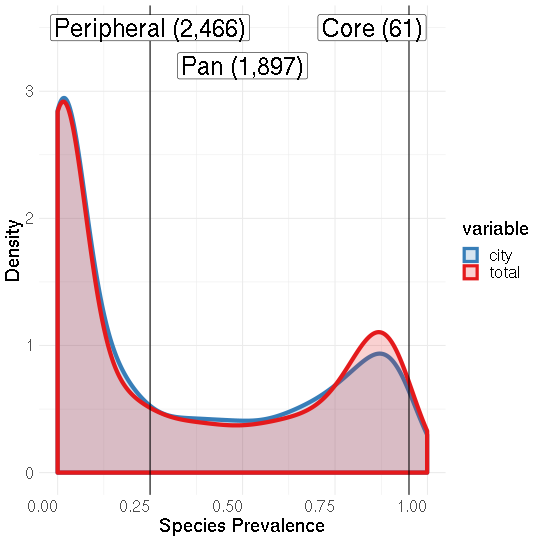

In [128]:
%%R -i prev_flat -h 540 -w 540

ggplot(prev_flat, aes(x=value, color=variable, fill=variable)) +
    geom_density(size=2, alpha=0.2) +
    theme_minimal() +
    xlab('Species Prevalence') +
    ylab('Density') +
    geom_vline(xintercept=0.25, color='black') +
    geom_vline(xintercept=0.95, color='black') +
    annotate(geom='label', x=0.5, y=3.2, label="Pan (1,897)", size=10) +
    annotate(geom='label', x=0.25, y=3.5, label="Peripheral (2,466)", size=10) +
    annotate(geom='label', x=0.85, y=3.5, label="Core (61)", size=10) +
    scale_color_brewer(palette = "Set1", direction=-1) +
    scale_fill_brewer(palette = "Set1", direction=-1) +
    theme(
        text=element_text(size=20),
        axis.text.x=element_text(angle = 0, hjust = 1)
    )

In [129]:
taxa = core_tabler.taxonomy(normalize=True)

city_medians = taxa.groupby(by=core_tabler.metadata['city']).median()

#top_taxa = city_medians.median().sort_values(ascending=False)[:50].index
#top_taxa = city_medians.mean().sort_values(ascending=False)[:50].index
top_taxa = taxa.mean().sort_values(ascending=False)[:75].index
taxa, city_medians = taxa[top_taxa], city_medians[top_taxa]

taxa_prev = (core_tabler.taxonomy(normalize=True) > 0).mean()[top_taxa]
city_prev_medians = (taxa.groupby(by=core_tabler.metadata['city']).median() > 0).mean()[top_taxa]

taxa = 1000 * 1000 * taxa
city_medians = 1000 * 1000 * city_medians
taxa_mean = taxa.mean()
taxa_kurtosis = taxa.kurtosis()
taxa_sd = taxa.std()

def add_stats(taxon):
    m, k, sd = taxa_mean[taxon], taxa_kurtosis[taxon], taxa_sd[taxon]
    return f'{taxon} OPCC{m // 1000:.0f}kCCC {sd // 1000:.0f}kCCC {k:.0f}CPCC'

top_taxa2 = top_taxa.copy()
taxa_stats = pd.Series({taxon: add_stats(taxon) for taxon in taxa.columns})
taxa.columns = [taxa_stats[taxon] for taxon in taxa.columns]
city_medians.columns = [taxa_stats[taxon] for taxon in city_medians.columns]
top_taxa = top_taxa.map(lambda x: taxa_stats[x])
taxa.head()

,Cutibacterium acnes OPCC116kCCC 151kCCC 3CPCC,Bradyrhizobium sp. BTAi1 OPCC60kCCC 109kCCC 5CPCC,Micrococcus luteus OPCC31kCCC 49kCCC 46CPCC,Pseudomonas stutzeri OPCC25kCCC 86kCCC 41CPCC,Moraxella osloensis OPCC15kCCC 46kCCC 120CPCC,Janibacter indicus OPCC10kCCC 36kCCC 115CPCC,Cupriavidus metallidurans OPCC10kCCC 20kCCC 52CPCC,Dermacoccus nishinomiyaensis OPCC9kCCC 41kCCC 138CPCC,Stenotrophomonas maltophilia OPCC9kCCC 31kCCC 115CPCC,Bradyrhizobium sp. SK17 OPCC8kCCC 15kCCC 9CPCC,...,Staphylococcus saprophyticus OPCC2kCCC 21kCCC 271CPCC,Brevundimonas vesicularis OPCC2kCCC 8kCCC 509CPCC,Massilia sp. WG5 OPCC2kCCC 6kCCC 258CPCC,Brevundimonas sp. GW460-12-10-14-LB2 OPCC2kCCC 7kCCC 837CPCC,Methylobacterium aquaticum OPCC2kCCC 4kCCC 160CPCC,Pseudomonas oryzihabitans OPCC2kCCC 12kCCC 464CPCC,Arsenicicoccus sp. oral taxon 190 OPCC2kCCC 5kCCC 598CPCC,Pantoea agglomerans OPCC2kCCC 13kCCC 808CPCC,Deinococcus swuensis OPCC2kCCC 8kCCC 291CPCC,Paracoccus contaminans OPCC2kCCC 3kCCC 45CPCC
uuid,,,,,,,,,,,,,,,,,,,,,
haib18CEM5453_HNHKFCCXY_SL346001,383236.702036,166017.177617,34715.981751,784.139218,11397.020703,15401.963156,28239.812671,3696.039125,2864.376318,22126.550997,...,62.644731,3328.811392,902.948191,3052.310510,948.311616,360.747244,604.845678,384.509038,401.790343,1779.974424
haib18CEM5453_HMGW3CCXY_SL342350,359069.315439,33201.215962,62882.246879,3985.206067,13541.829806,5036.523024,6350.468434,1296.276218,4663.060545,4357.062256,...,287.525952,766.200441,569.429887,767.806731,392.737962,950.120673,673.035607,2566.851792,495.540537,2612.631063
haib18CEM5453_HNHKFCCXY_SL345474,19579.497382,497480.715445,3148.067164,650.308500,259.065988,1328.562894,86455.531663,363.296618,2195.640894,55374.410776,...,9.063533,317.978953,604.990835,316.468364,2064.219664,101.964747,116.315341,15.105889,435.804883,404.837812
haib17CEM5106_HCCGHCCXY_SL270356,145360.105435,0.000000,47988.216141,2868.439414,9225.521358,8837.894410,0.000000,1317.931623,4186.371037,0.000000,...,1085.355454,930.304675,852.779285,1085.355454,697.728506,232.576169,2015.660129,0.000000,2558.337856,1860.609350
sossowski_BarcelonaNov2018_CSD16-BCN-256-29787-TCCTGAGC-TCTCTCCG,171474.827319,64.943800,17697.185614,923.129735,9300.879988,1099.405764,41.749586,115.971072,1080.850393,120.609915,...,408.218174,46.388429,78.860329,37.110743,0.000000,41.749586,190.192558,1502.985095,143.804129,176.276030


In [130]:
%%R -i taxa -i city_medians -i taxa_stats --height 1080 --width 460

taxa = melt(taxa)
taxa$kind = 'All Samples'
city_medians = melt(city_medians)
city_medians$kind = 'City Median'

taxa = rbind(taxa, city_medians)
head(taxa)

                                       variable     value        kind
1 Cutibacterium.acnes.OPCC116kCCC.151kCCC.3CPCC 383236.70 All Samples
2 Cutibacterium.acnes.OPCC116kCCC.151kCCC.3CPCC 359069.32 All Samples
3 Cutibacterium.acnes.OPCC116kCCC.151kCCC.3CPCC  19579.50 All Samples
4 Cutibacterium.acnes.OPCC116kCCC.151kCCC.3CPCC 145360.11 All Samples
5 Cutibacterium.acnes.OPCC116kCCC.151kCCC.3CPCC 171474.83 All Samples
6 Cutibacterium.acnes.OPCC116kCCC.151kCCC.3CPCC  11502.47 All Samples


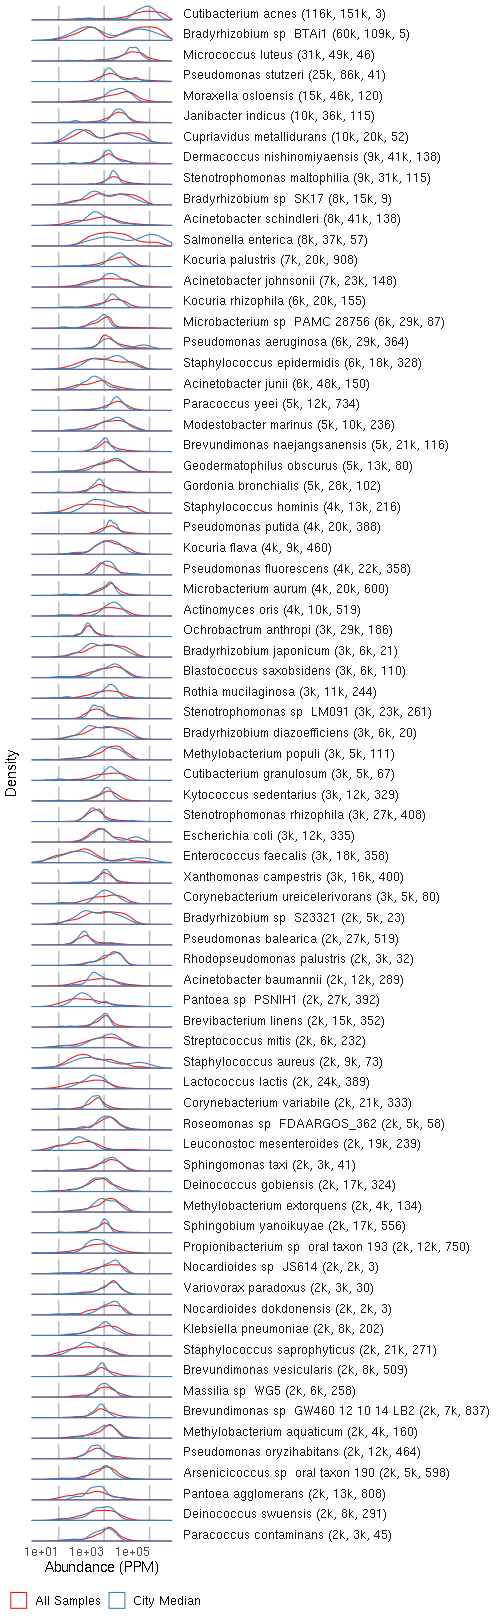

In [140]:
%%R -i taxa -i city_medians -i taxa_stats --height 1620 --width 500

taxa = melt(taxa)
taxa$kind = 'All Samples'
city_medians = melt(city_medians)
city_medians$kind = 'City Median'

taxa = rbind(taxa, city_medians)

#taxa$variable = gsub("\\.(?=\\.*)", " ", taxa$variable, perl=TRUE)

levels(taxa$variable) <- gsub("\\.(?=\\.*)", " ", levels(taxa$variable), perl=T)
levels(taxa$variable) <- gsub("OPCC", "(", levels(taxa$variable))
levels(taxa$variable) <- gsub("CPCC", ")", levels(taxa$variable))
levels(taxa$variable) <- gsub("CCC", ",", levels(taxa$variable))
#taxa$variable = as.character(taxa$variable)

ggplot(taxa, aes(x=value, color=kind)) +
    geom_density(size=0.5) +
    facet_grid(variable~., scales="free_y") +
    theme_minimal() +
    ylab('Density') +
    xlab('Abundance (PPM)') +
    scale_x_log10() +
    scale_color_brewer(palette = "Set1") +
    labs(color="") +
    theme(
        axis.text.x= element_text(angle=0, hjust=1),
        axis.text.y= element_blank(),
        strip.text.y= element_text(angle=0, hjust=0),
        text = element_text(size=15),
        panel.grid.major.x = element_line(colour = "grey",size=0.75),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom'
    )

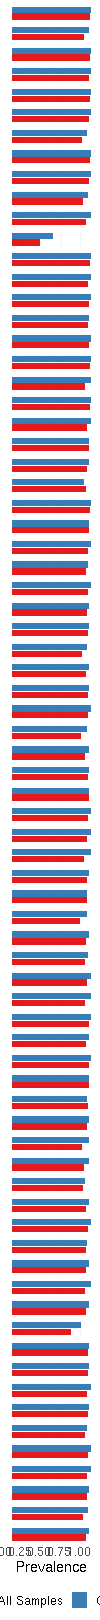

In [141]:
%%R -i taxa_prev -i city_prev_medians -i top_taxa2 --height 1620 --width 100

taxa_prev = data.frame(taxa_prev)
taxa_prev$kind = 'All Samples'
colnames(taxa_prev) = c('value', 'kind')
taxa_prev$taxon = as.factor(rownames(taxa_prev))

city_prev_medians = data.frame(city_prev_medians)
city_prev_medians$kind = 'City Median'
colnames(city_prev_medians) = c('value', 'kind')
city_prev_medians$taxon = as.factor(rownames(city_prev_medians))

taxa_prev = rbind(taxa_prev, city_prev_medians)
#taxa_prev$taxon = as.factor(rownames(taxa_prev))
taxa_prev$taxon = ordered(taxa_prev$taxon, levels=top_taxa2)


ggplot(taxa_prev, aes(x=kind, y=value, fill=kind)) +
    geom_col() +
    facet_grid(taxon~., scales="free_y") +
    theme_minimal() +
    ylab('Prevalence') +
    scale_fill_brewer(palette = "Set1") +
    labs(color="") +
    coord_flip() +
    theme(
        axis.text.x=element_text(angle=0, hjust=1),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        strip.text.y=element_blank(),
        text = element_text(size=15),
        panel.grid.major = element_blank(),
        #panel.grid.minor = element_blank(),
        legend.position='bottom'
    )

In [160]:
taxa = core_tabler.taxonomy(normalize=True)
taxa['continent'] = core_tabler.metadata['continent']
taxa['surface'] = core_tabler.metadata['surface_ontology_fine']
taxa['continent'] = [str(el) for el in taxa['continent']]
taxa['surface'] = [str(el) for el in taxa['surface']]

cacnes = taxa[['continent', 'Cutibacterium acnes']]
brad =  taxa[['continent', 'Bradyrhizobium sp. BTAi1']]
cmet =  taxa[['surface', 'Cupriavidus metallidurans']]

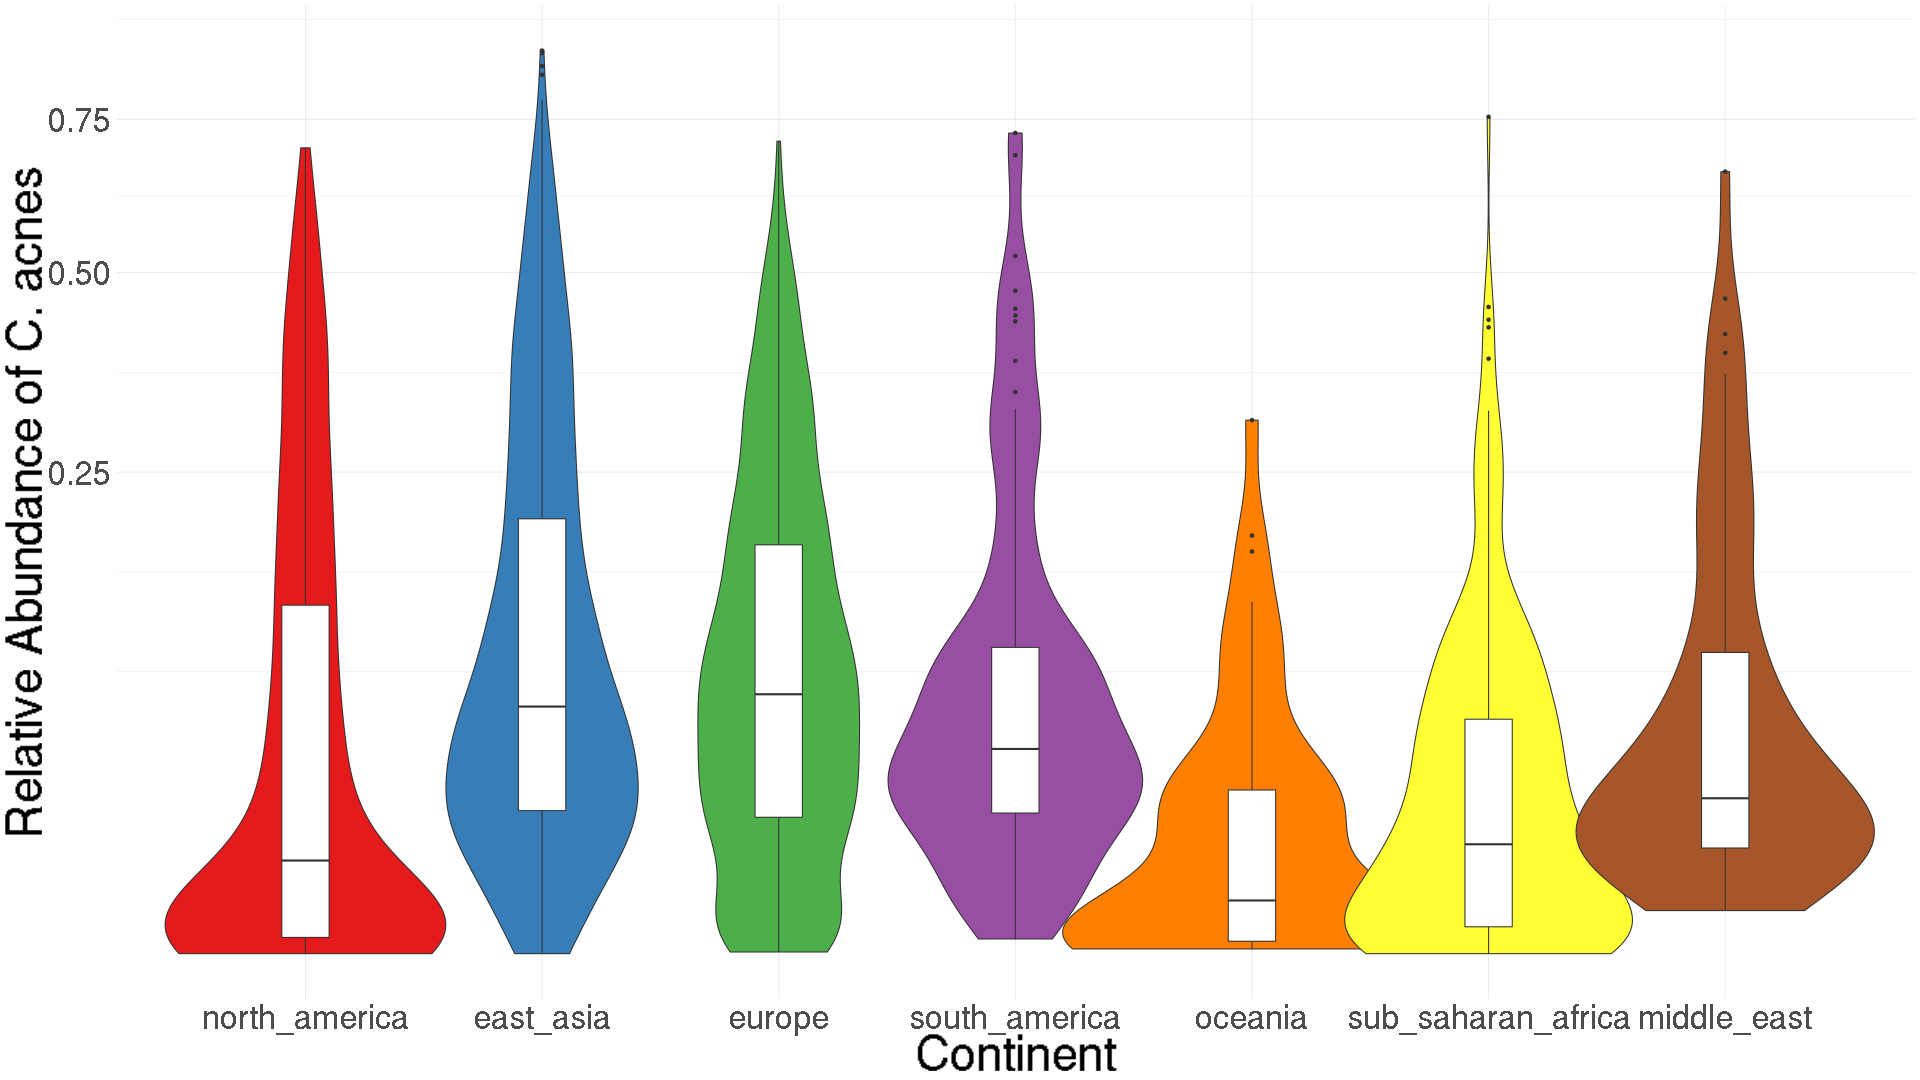

In [145]:
%%R -i cacnes -w 1920 -h 1080

conts =  c(
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
)
cacnes$continent = ordered(
    cacnes$continent,
    levels=conts
)

ggplot(cacnes[cacnes$continent %in% conts,], aes(x=continent, y=Cutibacterium.acnes, fill=continent)) +
    geom_violin(width=1.6) +
    geom_boxplot(fill='white', width=0.2) +
    scale_y_sqrt() +
    theme_minimal() +
    scale_fill_brewer(palette='Set1') +
    xlab('Continent') +
    ylab('Relative Abundance of C. acnes') +
    theme(
        text = element_text(size=50),
        legend.position='none',
    )

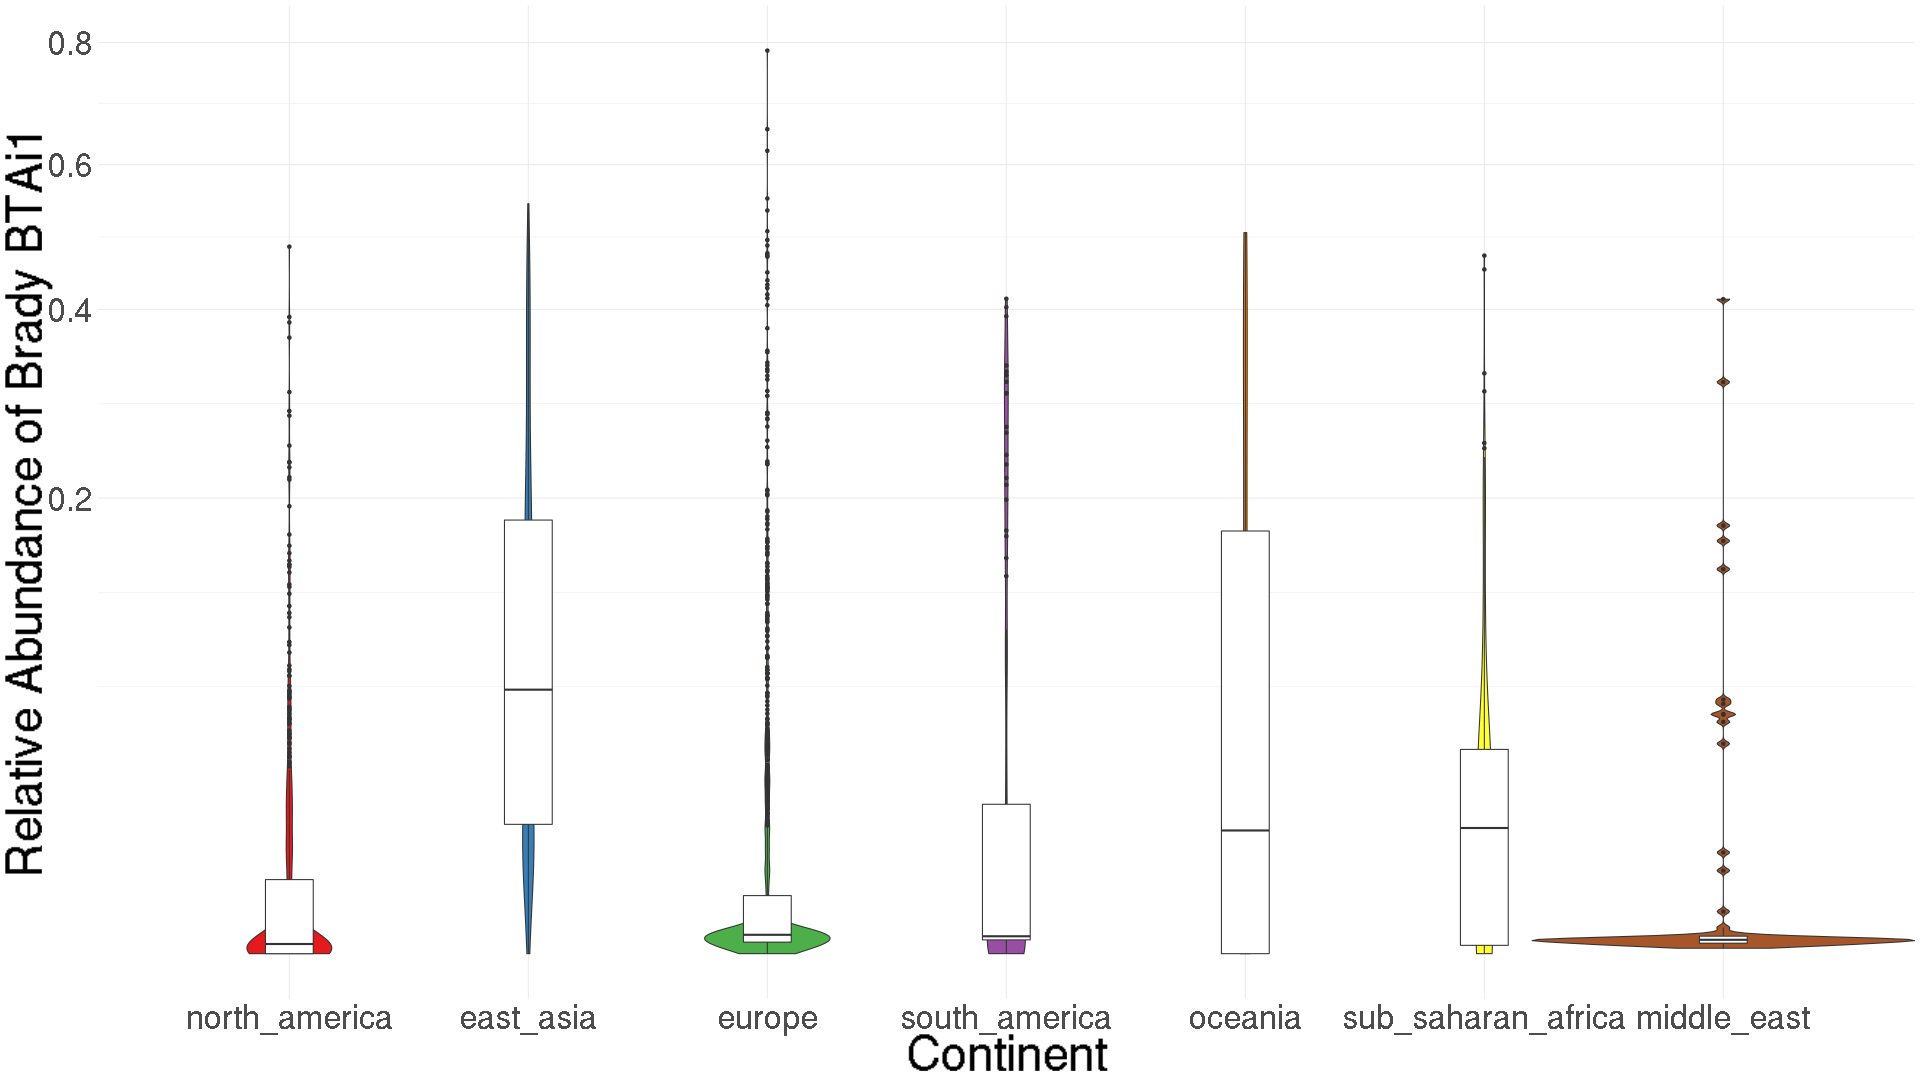

In [155]:
%%R -i brad -w 1920 -h 1080

conts =  c(
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
)
brad$continent = ordered(
    brad$continent,
    levels=conts
)

ggplot(brad[brad$continent %in% conts,], aes(x=continent, y=Bradyrhizobium.sp..BTAi1, fill=continent)) +
    geom_violin(width=1.6) +
    geom_boxplot(fill='white', width=0.2) +
    scale_y_sqrt() +
    theme_minimal() +
    scale_fill_brewer(palette='Set1') +
    xlab('Continent') +
    ylab('Relative Abundance of Brady BTAi1') +
    theme(
        text = element_text(size=50),
        legend.position='none',
    )

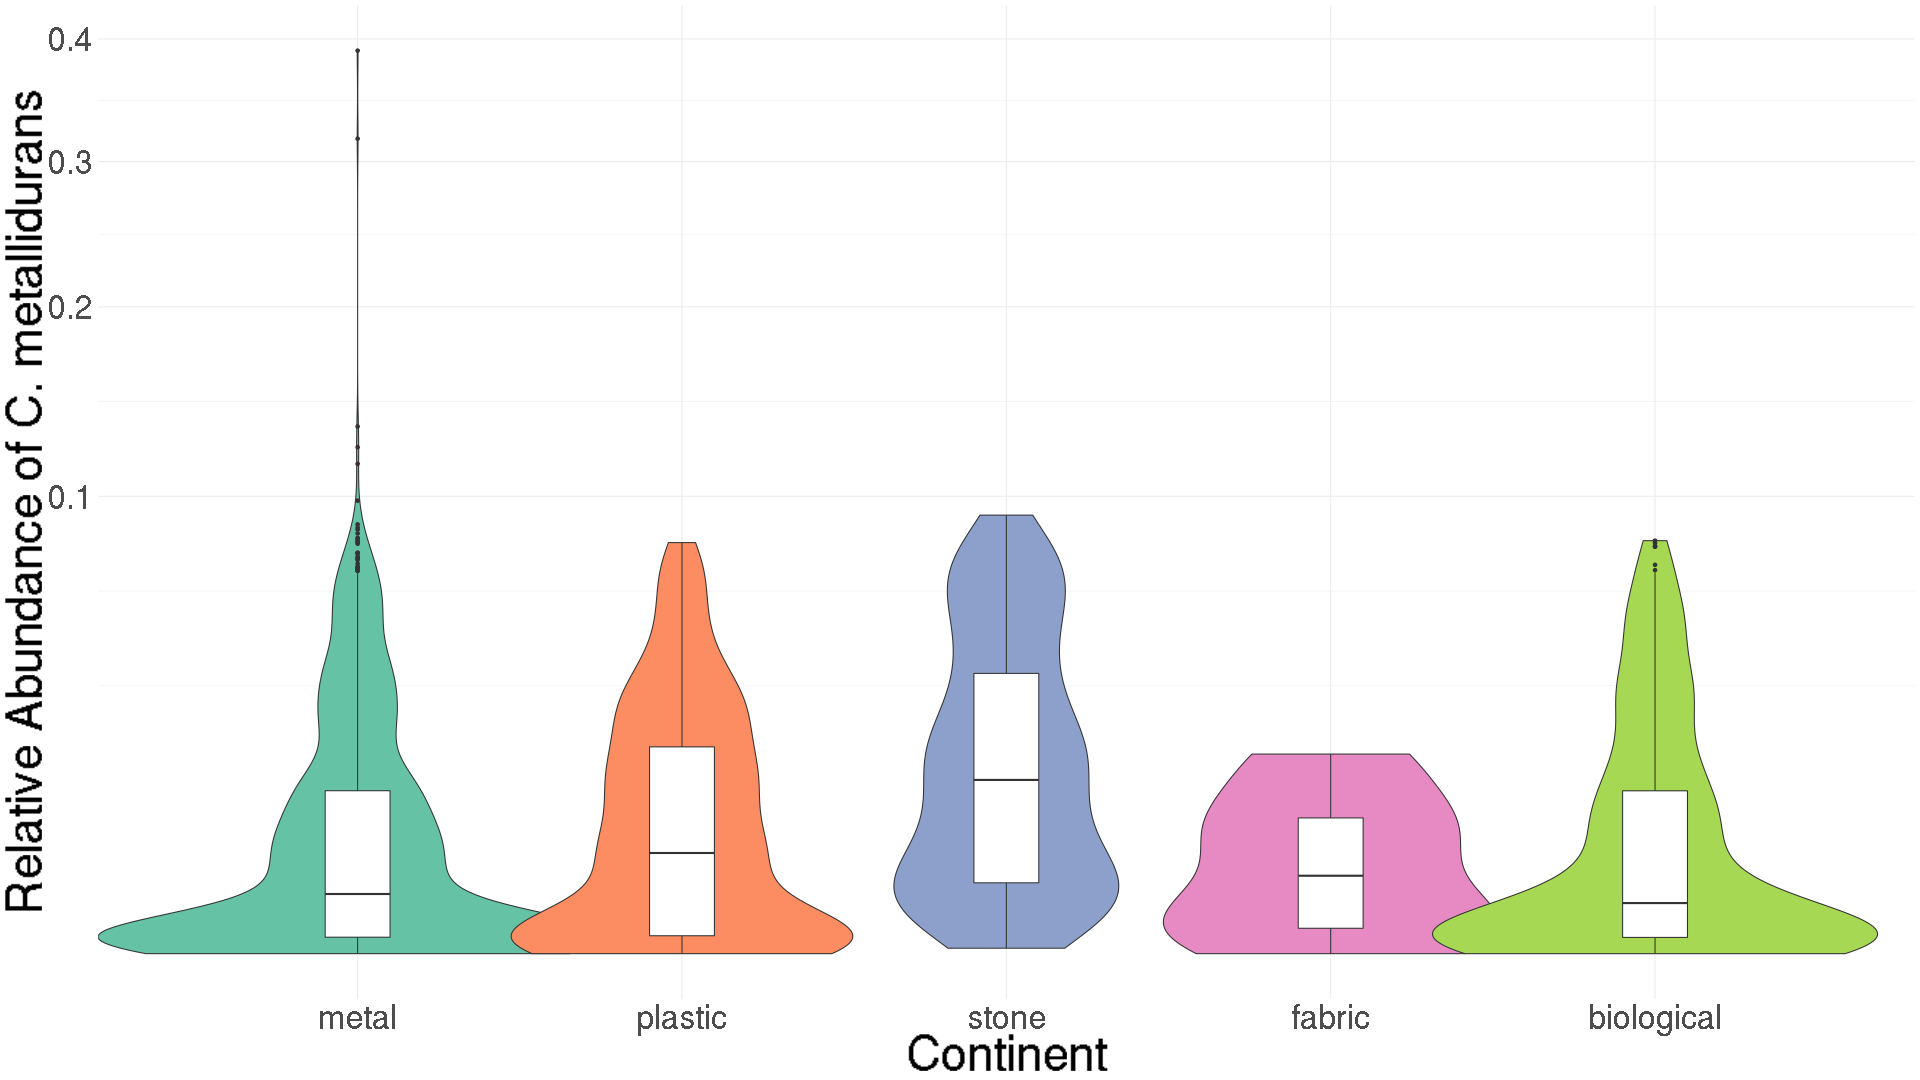

In [163]:
%%R -i cmet -w 1920 -h 1080

surfaces = c('metal', 'plastic', 'stone', 'fabric', 'biological')
cmet$surface = ordered(cmet$surface, levels=surfaces)

ggplot(cmet[cmet$surface %in% surfaces,], aes(x=surface, y=Cupriavidus.metallidurans, fill=surface)) +
    geom_violin(width=1.6) +
    geom_boxplot(fill='white', width=0.2) +
    scale_y_sqrt() +
    theme_minimal() +
    scale_fill_brewer(palette='Set2') +
    xlab('Continent') +
    ylab('Relative Abundance of C. metallidurans') +
    theme(
        text = element_text(size=50),
        legend.position='none',
    )

In [146]:
from scipy.cluster.hierarchy import linkage, cophenet, leaves_list
from scipy.spatial.distance import squareform, pdist

taxa = core_tabler.taxonomy()
prevalence = (taxa > 0).sum().sort_values()

taxa_order_prev = list(prevalence[prevalence >= 10].index)

FNAME = '.taxa_jaccard_cache.csv'
if isfile(FNAME):
    taxa_jaccard = pd.read_csv(FNAME, index_col=0)
else:
    btaxa = (taxa > 0).T
    distm = squareform(pdist(btaxa, metric='jaccard'))
    taxa_jaccard = pd.DataFrame(distm, index=btaxa.index, columns=btaxa.index)
    taxa_jaccard.to_csv(FNAME)
    

Z = linkage(squareform(taxa_jaccard), 'average')
print(cophenet(Z, squareform(taxa_jaccard))[0])
taxa_order = taxa.columns[leaves_list(Z)]
    
taxa_jaccard_long = taxa_jaccard.copy()
taxa_jaccard_long['taxa'] = taxa_jaccard_long.index
taxa_jaccard_long = taxa_jaccard_long.melt(id_vars=['taxa'])
taxa_jaccard_long_sub = taxa_jaccard_long.sample(n=100000)
taxa_jaccard_long.head()

0.975896337360644


,taxa,variable,value
0,Enterobacter sp. FY-07,Enterobacter sp. FY-07,0.000000
1,Enterobacter sp. R4-368,Enterobacter sp. FY-07,0.338315
2,Enterobacter sp. 638,Enterobacter sp. FY-07,0.480758
3,Enterobacter sp. CRENT-193,Enterobacter sp. FY-07,0.766370
4,Enterobacter sp. E20,Enterobacter sp. FY-07,0.554315


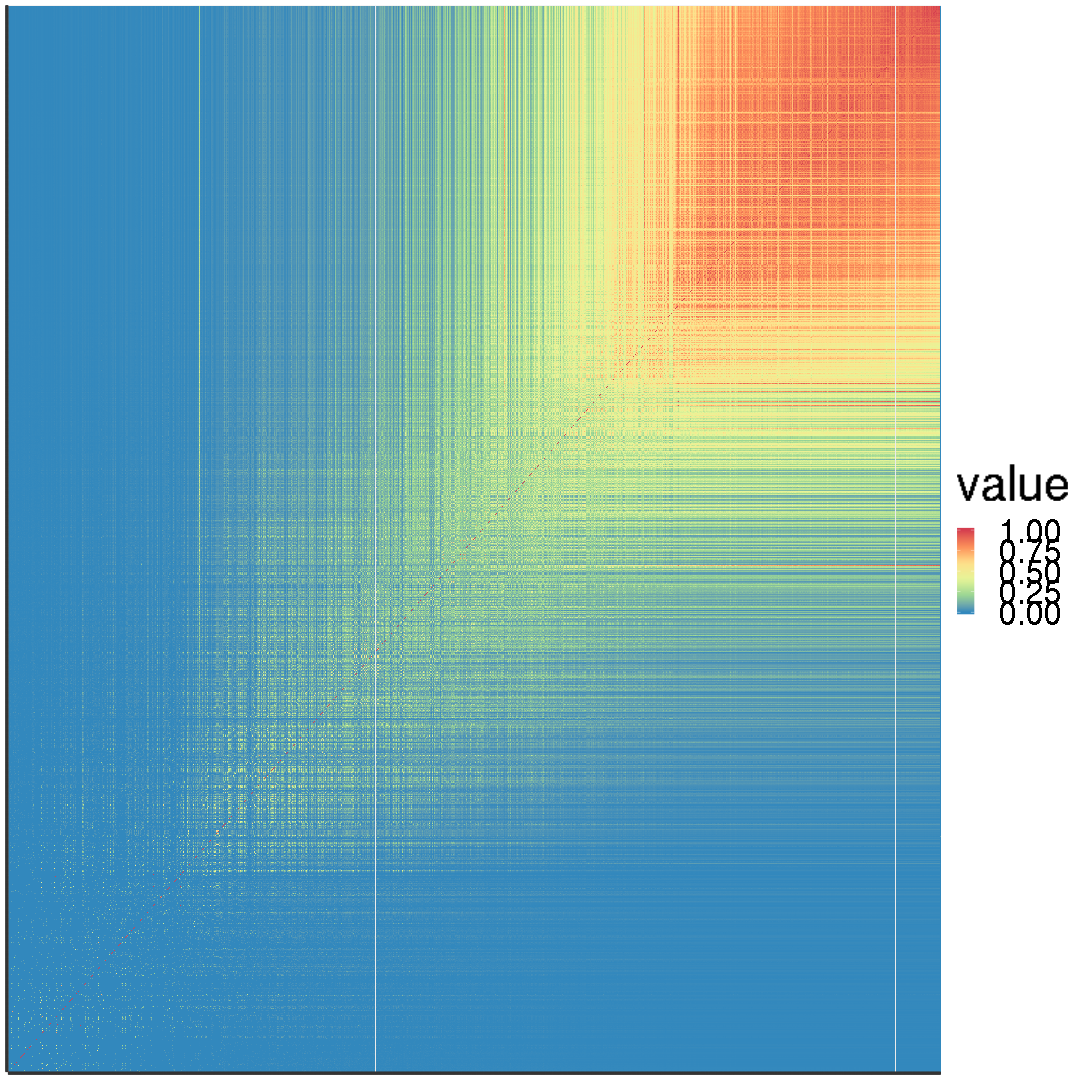

In [147]:
%%R -i taxa_jaccard_long -i taxa_order_prev -w 1080 -h 1080

taxa_jaccard_long$taxa = ordered(
    taxa_jaccard_long$taxa,
    levels=taxa_order_prev
)
taxa_jaccard_long$variable = ordered(
    taxa_jaccard_long$variable,
    levels=taxa_order_prev
)
taxa_jaccard_long$value = 1 - taxa_jaccard_long$value

ggplot(taxa_jaccard_long, aes(x=taxa, y=variable, fill=value)) +
    geom_tile() +
    scale_fill_distiller(palette='Spectral', direction=-1) +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='right',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
    )